# FFT Audio Data EDA

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data = np.load("Dataset/whistle.npy")

In [43]:
data.max()

13629.98

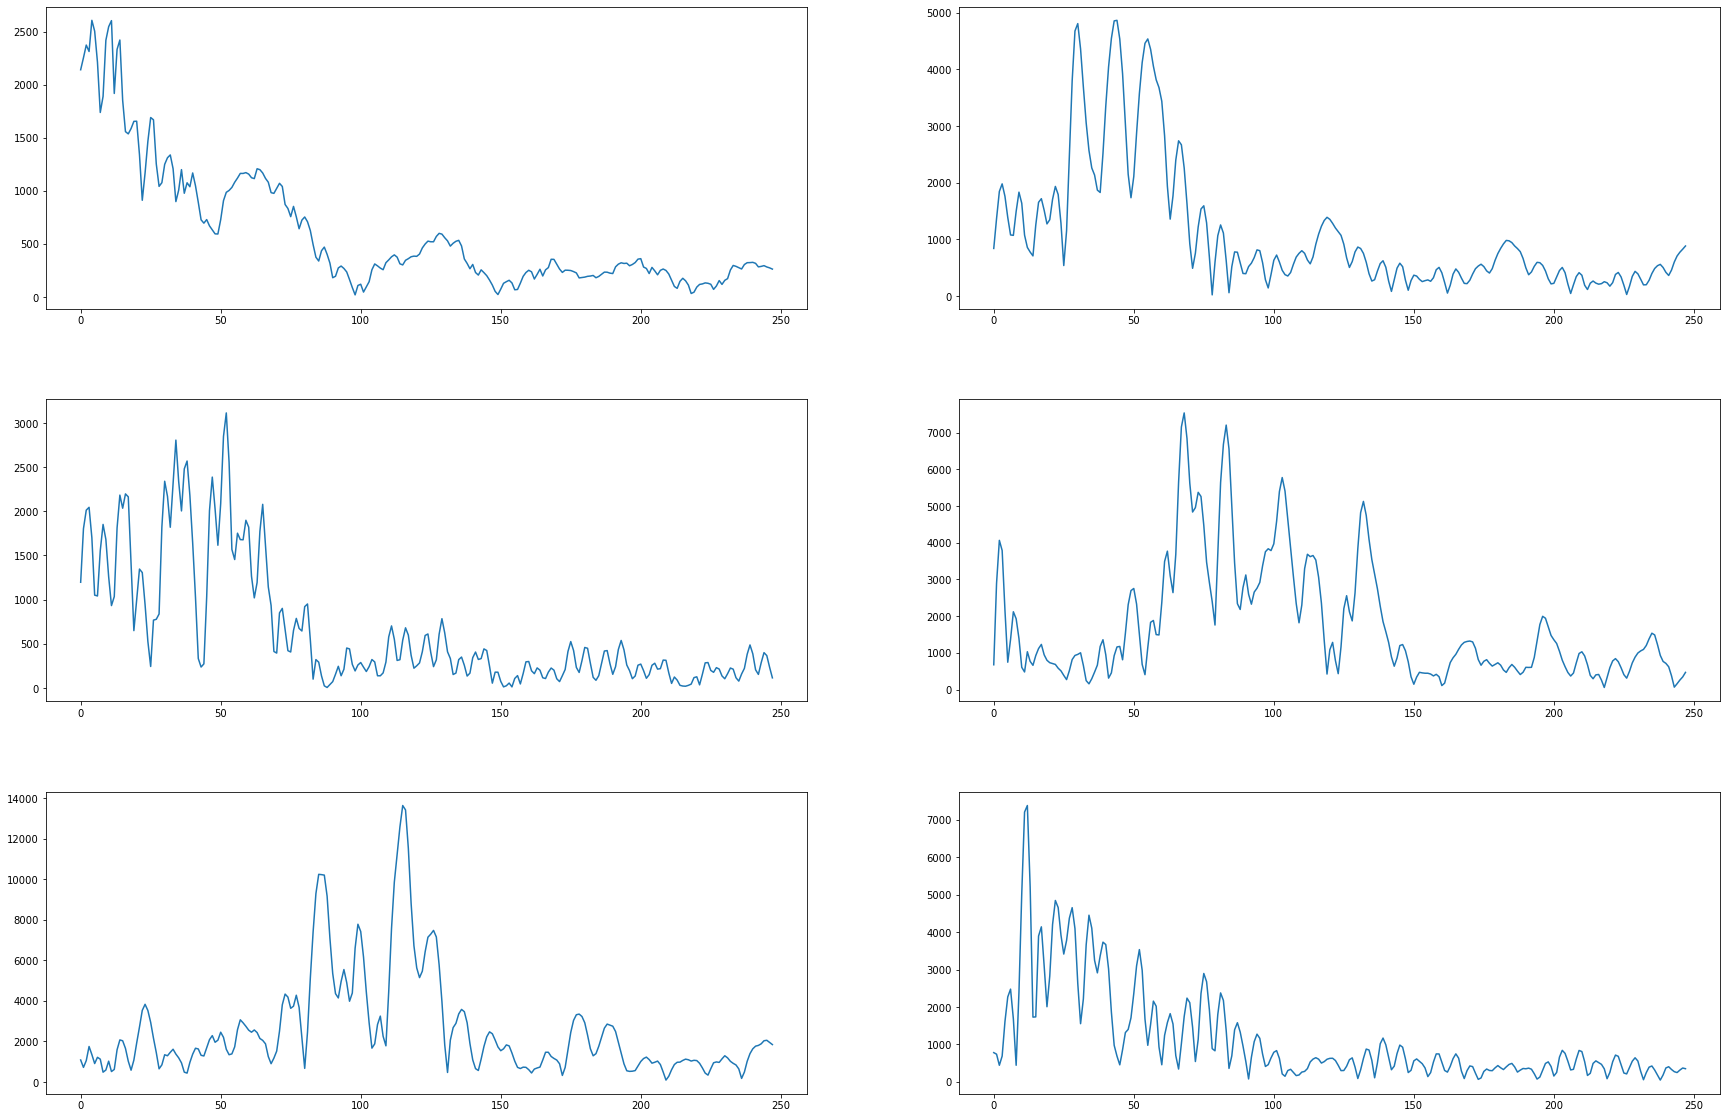

In [38]:
def plot_all_fft_audio(): 
    fig = plt.figure(figsize=(30,20))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    
    
    for i in range(6):      
        plt.subplot(3,2, i+1)
        plt.plot(data[i].reshape(-1,1))
        
plot_all_fft_audio()